# ChatBot with multiple Tools using LangGraph
### Aim: 
Create a chatbot with tool capabilities from arxiv, wikipedia search and some functions

In [1]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper

In [2]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500) # get top 2 results and max 500 characters 
arxiv = ArxivQueryRun(api_wrapper = api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [3]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [4]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500) # get top 1 result and max 500 characters 
wiki = WikipediaQueryRun(api_wrapper = api_wrapper_wiki)
print(wiki.name)

wikipedia


In [5]:
wiki.invoke("What is Machine Learning?")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [6]:
from dotenv import load_dotenv
load_dotenv()
import os

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [7]:
# Tavily search tool is a search engine built specially for AI agents delivering real time, accurate and factual results at speed 
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

C:\Users\Sujit Khare\AppData\Local\Temp\ipykernel_20432\4153934112.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [8]:
tavily.invoke("provide me recent AI news")

[{'title': 'The latest AI news we announced in June - Google Blog',
  'url': 'https://blog.google/technology/ai/google-ai-updates-june-2025/',
  'content': '# The latest AI news we announced in June\n\nJul 02, 2025\n\nHere’s a recap of some of our biggest AI updates from June, including more ways to search with AI Mode, a new way to share your NotebookLM notebooks publicly, and a new AI to help researchers better understand the human genome.\n\nSuperG\n\n## Basic explainer [...] For more than 20 years, we’ve invested in machine learning and AI research, tools and infrastructure to build products that make everyday life better for more people. Teams across Google are working on ways to unlock AI’s benefits in fields as wide-ranging as healthcare, crisis response and education. To keep you posted on our progress, we\'re doing a regular roundup of Google\'s most recent AI news.\n\nHere’s a look back at some of our AI announcements from June. [...] a text card reading "AI to revolutionize 

In [9]:
# combine all tools 
tools = [arxiv, wiki, tavily]

In [10]:
# initialize my llm model
from langchain_groq import ChatGroq
llm = ChatGroq(model= "gemma2-9b-it")

llm_with_tools = llm.bind_tools(tools)

In [11]:
from langchain_core.messages import HumanMessage, AIMessage
llm_with_tools.invoke([HumanMessage(content = f"Hey, What is the recent AI news?")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news'},
  'id': '6wftk7hkt',
  'type': 'tool_call'}]

In [12]:
# defining state schema
from typing_extensions import TypedDict
from typing import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

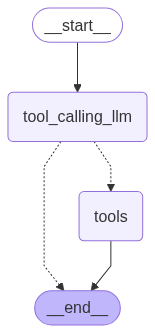

In [13]:
# creating entire chatbot with LangGraph
from IPython.display import display, Image
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

# Node definition
def tool_calling_llm(state:State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)
builder.add_edge("tools", END) 

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
messages = graph.invoke({"messages":HumanMessage(content="What is attention is all you need?")})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is attention is all you need?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (8rpxkapt1)
 Call ID: 8rpxkapt1
  Args:
    query: attention is all you need
================================= Tool Message =================================
Name: wikipedia

Page: Attention Is All You Need
Summary: "Attention Is All You Need" is a 2017 landmark research paper in machine learning authored by eight scientists working at Google. The paper introduced a new deep learning architecture known as the transformer, based on the attention mechanism proposed in 2014 by Bahdanau et al. It is considered a foundational paper in modern artificial intelligence, and a main contributor to the AI boom, as the transformer approach has become the main architecture of a wi


In [15]:
messages = graph.invoke({"messages":HumanMessage(content="Provide me the top recent AI news for July 15th 2025")})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Provide me the top recent AI news for July 15th 2025
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (tm9y3419z)
 Call ID: tm9y3419z
  Args:
    query: top AI news July 15th 2025
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Latest AI Breakthroughs and News: May, June, July 2025 | News", "url": "https://www.crescendo.ai/news/latest-ai-news-and-updates", "content": "### Pentagon Taps 4 Tech Firms to Expand Military AI Capabilities\n\nDate: July 15, 2025\n\nSummary: The U.S. Department of Defense has partnered with four commercial tech companies to accelerate AI integration into military operations. The contracts focus on logistics automation, battlefield decision support, and threat analysis. Officials say rapid deployment of AI is critical for maintaini

In [16]:
messages = graph.invoke({"messages":HumanMessage(content="What is machine learning?")})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is machine learning?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (cdtpnajzc)
 Call ID: cdtpnajzc
  Args:
    query: machine learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML fi
